In [2]:
%cd turnus
%load_ext autoreload
%autoreload 2

[Errno 2] No such file or directory: 'turnus'
/home/dmatis/s/ssd/rl-optimization/turnus


In [76]:
import torch
import pandas as pd
import numpy as np

def load_node_csv(path: str, index_col: str, encoders=None, **kwargs):
    df = pd.read_csv(path, index_col=index_col, **kwargs)
    mapping = {index: i for i, index in enumerate(df.index.unique())}

    x = None
    if encoders is not None:
        xs = [encoder(df[col]) for col, encoder in encoders.items()]
        x = torch.cat(xs, dim=-1)
        df = df[encoders.keys()].copy()

    return x, mapping, df

def build_edge_connections(time_matrix_path: str, start_times: np.array, finish_times: np.array, delimiter=';'):
    matrix = np.loadtxt(time_matrix_path, delimiter=delimiter)
    # Add the transport times (matrix) to the finishing time of every task
    transport_times = matrix + np.expand_dims(finish_times, axis=-1)

    possible_connection = np.where(transport_times <= start_times)

    return torch.tensor(np.array(possible_connection))


In [4]:
class IdentityEncoder:
    def __init__(self, dtype=None):
        self.dtype = dtype

    def __call__(self, df):
        return torch.from_numpy(df.values).view(-1, 1).to(self.dtype)

In [5]:
# Normalize and convert dataframe column (Series) into a tensor
class NumberNormEncoder:
    def __init__(self, dtype=None):
        self.dtype = dtype

    def __call__(self, df):
        return torch.from_numpy(((df - df.mean()) / df.std()).values).view(-1, 1).to(self.dtype)

In [6]:
from torch_geometric.data import Data
import torch_geometric.transforms as T

nodes, mapping, df = load_node_csv('data/1/tasks.csv', 'Index', 
                               {name: NumberNormEncoder() for name in ['ZastavkaStart', 'ZastavkaFinish', 'CasStart', 'CasFinish', 'Vzdialenost']}, 
                               sep=';')

# extra_features = torch.zeros((nodes.shape[0], 1))

# nodes = torch.cat((nodes, extra_features), 1)

edge_connections = build_edge_connections('data/1/Tij.csv', df['CasStart'].values, df['CasFinish'].values)

data = Data(x=nodes, edge_index=edge_connections)

c = T.Constant(0)


data = c(data)
data.x[0, 5] = 1

data

C:\Users\David\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)


Data(x=[51, 6], edge_index=[2, 1195])

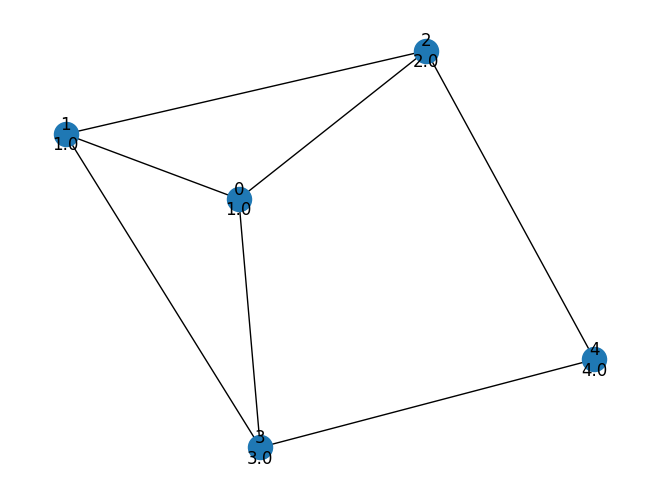

In [39]:
import torch
from torch_geometric.data import Data, Batch
from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_networkx
from env import Env
import networkx as nx

nodes = torch.Tensor([[1], [1], [2], [3], [4]])
edges = torch.Tensor([[0,1], [0,2], [0,3], [1,2], [1,3], [2,4], [3,4]]).to(torch.long).contiguous().t()
data = Data(x=nodes, edge_index=edges)

g = to_networkx(data, to_undirected=True)

g = nx.relabel_nodes(g, lambda i: f'{i}\n{data.x[i].item()}')

pos = nx.spring_layout(g, seed=46)
nx.draw(g, pos, with_labels=True)


tensor([[1.0000, 0.0000, 0.0000],
        [1.0000, 0.2000, 1.0000],
        [2.0000, 0.0000, 0.0000],
        [3.0000, 0.0000, 0.0000],
        [4.0000, 0.0000, 0.0000]]) tensor([False, False,  True,  True, False]) 0 False


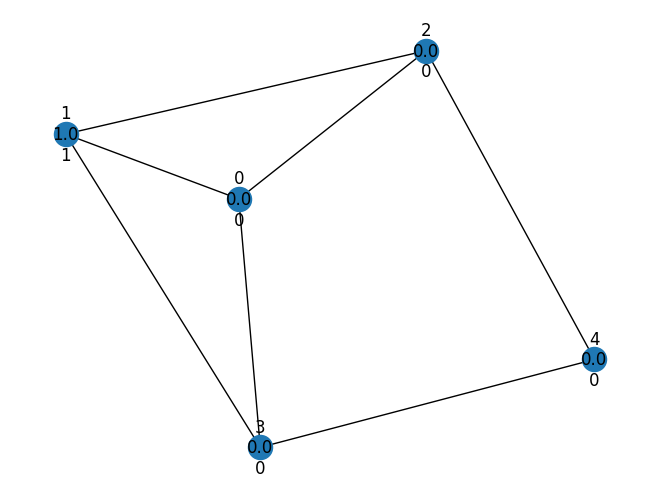

tensor([[1.0000, 0.0000, 0.0000],
        [1.0000, 0.2000, 0.0000],
        [2.0000, 0.2000, 1.0000],
        [3.0000, 0.0000, 0.0000],
        [4.0000, 0.0000, 0.0000]]) tensor([False, False, False, False,  True]) 0 False


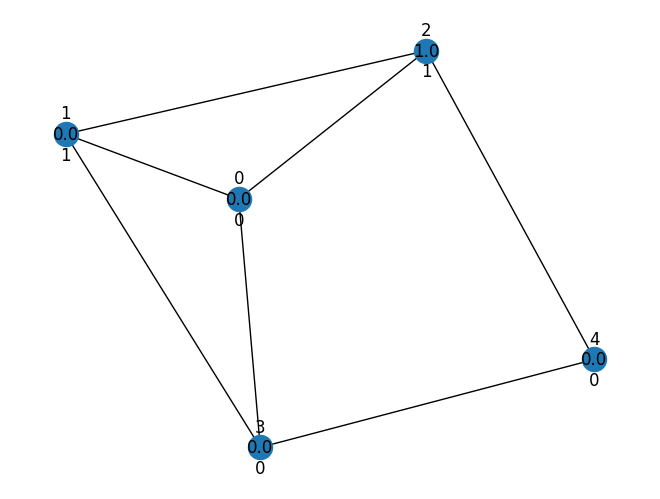

tensor([[1.0000, 0.0000, 1.0000],
        [1.0000, 0.2000, 0.0000],
        [2.0000, 0.2000, 0.0000],
        [3.0000, 0.0000, 0.0000],
        [4.0000, 0.0000, 0.0000]]) tensor([False, False, False,  True, False]) 0 False


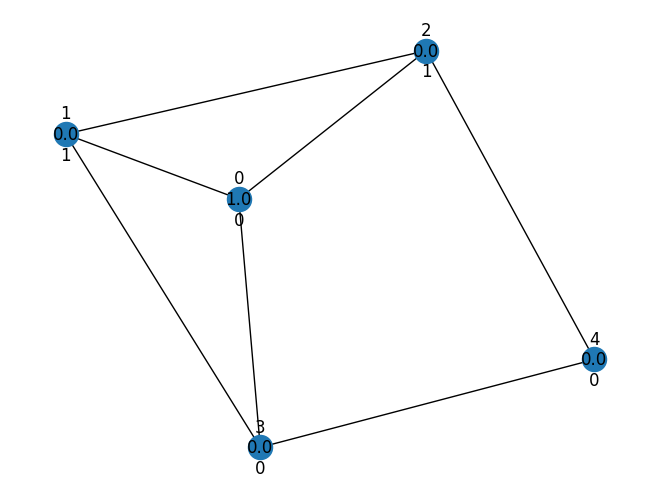

tensor([[1.0000, 0.0000, 0.0000],
        [1.0000, 0.2000, 0.0000],
        [2.0000, 0.2000, 0.0000],
        [3.0000, 0.4000, 1.0000],
        [4.0000, 0.0000, 0.0000]]) tensor([False, False, False, False,  True]) 0 False


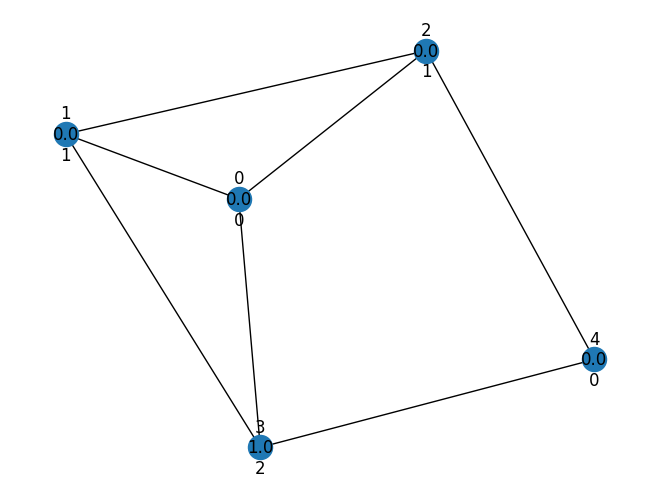

tensor([[1.0000, 0.0000, 1.0000],
        [1.0000, 0.2000, 0.0000],
        [2.0000, 0.2000, 0.0000],
        [3.0000, 0.4000, 0.0000],
        [4.0000, 0.0000, 0.0000]]) tensor([False, False, False, False, False]) 1.0 True


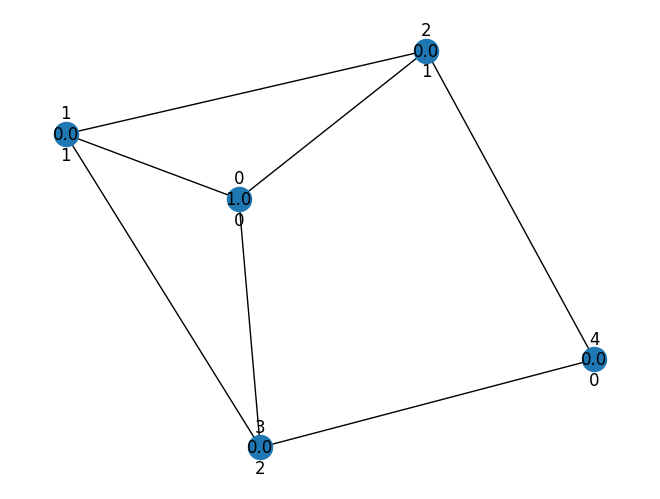

In [40]:
import matplotlib.pyplot as plt
env = Env(data)

def p(tpl):
    g, mask, reward, terminal, _ = tpl
    print(g.x, mask, reward, terminal)
    draw(g)

def draw(graph):
    g = to_networkx(graph, to_undirected=True)

    g = nx.relabel_nodes(g, lambda i: f'{i}\n{graph.x[i, env.flag_current_node_index].item()}\n{int(graph.x[i, env.flag_visited_index].item() * env.MAX_VEHICLES)}')

    pos = nx.spring_layout(g, seed=46)
    nx.draw(g, pos, with_labels=True)
    plt.show()

p(env.step(1))
p(env.step(2))
p(env.step(4))

p(env.step(3))
p(env.step(4))

In [28]:
from graph_utils import load_graph

nodes = torch.Tensor([[0], [1], [2], [3], [4]]).float()
edges = torch.Tensor([[0,1], [0,2], [0,3], [1,2], [1,3], [2,4], [3,4]]).to(torch.long).contiguous().t()
data = Data(x=nodes, edge_index=edges).to('cuda')

graph = load_graph('data/1').to('cuda')

conv1 = GCNConv(graph.num_node_features, 16).to('cuda')

res = conv1(graph.x, graph.edge_index)
res

tensor([[ 1.1289e-01,  7.4334e-02, -1.3711e+00,  3.7452e+00,  9.1868e-01,
         -1.8486e-01, -2.6172e+00,  3.7149e+00, -2.5364e+00, -2.9695e+00,
         -1.3354e+00,  4.2384e+00, -2.9071e+00,  2.4402e+00,  2.5669e+00,
          1.4587e+00],
        [ 2.9486e-01,  7.5221e-01, -8.4316e-01,  2.4109e+00,  1.0280e+00,
         -5.6952e-01, -1.6184e+00,  3.0113e+00, -1.5261e+00, -2.0286e+00,
         -7.8992e-01,  3.0354e+00, -2.0127e+00,  1.9157e+00,  1.6437e+00,
          1.0679e+00],
        [ 2.8714e-01,  7.3398e-01, -8.4900e-01,  2.4136e+00,  1.0180e+00,
         -5.5625e-01, -1.6190e+00,  2.9914e+00, -1.5295e+00, -2.0213e+00,
         -7.9555e-01,  3.0280e+00, -2.0037e+00,  1.9027e+00,  1.6485e+00,
          1.0684e+00],
        [ 2.8456e-01,  7.2791e-01, -8.5094e-01,  2.4145e+00,  1.0147e+00,
         -5.5182e-01, -1.6192e+00,  2.9847e+00, -1.5307e+00, -2.0189e+00,
         -7.9742e-01,  3.0255e+00, -2.0007e+00,  1.8983e+00,  1.6501e+00,
          1.0686e+00],
        [ 3.0519e-01

In [7]:
import torch
from graph_store import GraphStore

store = GraphStore((2, 3))

store[0] = [1,2,3]
store[1] = [4,5,6]

store.flatten()

[1, 2, 3, 4, 5, 6]

In [9]:
from utils import obj_to_reward, reward_to_obj

reward_to_obj(obj_to_reward(50, 4, 50), 4, 50)

50.0